<a href="https://colab.research.google.com/github/jwhan1129/Basic-Machine-learning-Codes/blob/master/BiS800_project3_textgeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. Environmental setting

In [0]:
# training dataset을 다운로드
!git clone https://github.com/alexarnimueller/LSTM_peptides

Cloning into 'LSTM_peptides'...
remote: Enumerating objects: 247, done.
remote: Total 247 (delta 0), reused 0 (delta 0), pack-reused 247
Receiving objects: 100% (247/247), 254.58 KiB | 866.00 KiB/s, done.
Resolving deltas: 100% (141/141), done.


In [0]:
!pip install modlamp

     |████████████████████████████████| 8.0MB 1.4MB/s 
     |████████████████████████████████| 163kB 51.2MB/s 
  Created wheel for modlamp: filename=modlamp-4.1.4-cp36-none-any.whl size=173968 sha256=38b1de7d5f215f96a831083bd22d8bef784538fde4dca929889871b205a7438b
  Stored in directory: /root/.cache/pip/wheels/a8/fd/e0/d87da8820407ab9b1bc4725bf63b0fcdd63281490e902a2678
Successfully built modlamp


In [0]:
# 필요한 모듈 import
import pandas as pd
import tensorflow as tf
import numpy as np
import os
from tqdm import tqdm
import time
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import itertools
import sys
import random
import tensorflow.keras.backend as K
import scipy
import modlamp

In [0]:
# 함수 내 진행상황을 시각화 하는 function 미리 선언
def printProgress (iteration, total, prefix = '', suffix = '', decimals = 1, barLength = 100): 
  formatStr = "{0:." + str(decimals) + "f}"
  percent = formatStr.format(100 * (iteration / float(total)))
  filledLength = int(round(barLength * iteration / float(total)))
  bar = '#' * filledLength + '-' * (barLength - filledLength)
  sys.stdout.write('\r%s |%s| %s%s %s' % (prefix, bar, percent, '%', suffix))
  if iteration == total:
    sys.stdout.write('\n')
  sys.stdout.flush()


# 1. Data preprocessing

In [0]:
# dataset을 열어 저장
f = open("/content/LSTM_peptides/training_sequences_noC.csv", 'r')
text = f.read()
f.close()

In [0]:
# One hot codding 을 위하여 input의 종류를 파악

vocab = [item for item in text]
vocab = sorted(set(vocab))
print ('고유 문자수 {}개'.format(len(vocab)))
print(vocab)

고유 문자수 20개
['\n', 'A', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']


In [0]:
# 앞서 알아낸 input의 고유 문자수를 기반으로
# 문자열 input을 idx로 parsing

char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

## 1) RNN data parsing

In [0]:
# 단일 입력에 대해 원하는 문장의 최대 길이
seq_length = 100
examples_per_epoch = len(text)//seq_length

# 훈련 샘플(앞 sequence) / 타겟 샘플 (한 문자열 뒤 서열) 생성
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

# Dataset을 map 형태로 변형
dataset = sequences.map(split_input_target)

batch_size = 32
buffer_size = 100000

# 선언된 버퍼에 sequence data를 넣고 섞어줌
# sequence의 총 길이는 3만 서열 정도로 10만 크기의 버퍼로 충분
# Drop_remainder 를 통해 일정 길이 이하의 sample은 Drop 시킴
dataset = dataset.shuffle(buffer_size, seed=10).batch(batch_size, drop_remainder=True)

# Validation set을 위한 상수 선언
validation_ratio = 0.2
num_elements = 0

for element in dataset:
    num_elements += 1

# 셔플 된 Dataset의 Validation_ratio 만큼의 초기 sample을 Validation set에 담고
# 이후 서열을 Training set에 담아 Dataset 준비 완료
validation_count = int(validation_ratio * num_elements)
training_count = int((1-validation_ratio)* num_elements)
val_dataset = dataset.take(validation_count)
training_dataset = dataset.skip(validation_count).take(training_count)

## 2) CNN data parsing

In [0]:
# CNN input을 위해 input sequence를 categorical data로 변경
text2int = tf.keras.utils.to_categorical(text_as_int, 20)

seq_length = 200
input_data = []
label_data = []

# Seq_length 길이의 서열을 input으로, 한 단어 뒤의 서열을 Label로 선언
for i in range(len(text2int)-seq_length):
  input_data.append(text2int[i:i+seq_length])
  label_data.append(text2int[i+1:i+seq_length+1])

input_data = np.asarray(input_data, dtype=float)
label_data = np.asarray(label_data, dtype=float)

# sklearn의 tarin_test_split을 활용하여 input을 나누어줌
X_train, X_val, y_train, y_val = train_test_split(input_data, label_data, test_size=0.2, random_state=1 )

print(X_val.shape)
print(y_val.shape)

(6743, 200, 20)
(6743, 200, 20)


# 2. Generative Models

##1) RNN Model

### a) Build and train RNN model

In [0]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size, file_name):
  model = tf.keras.Sequential([
    # 주어진 sequence를 작은 embedding space에 배치시키는 layer
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
                               
    # 이전 상태를 저장하며 각 단계에 Dense layer로 output을 내는 LSTM layer                           
    tf.keras.layers.LSTM(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    
    # 두번의 Dropout layer를 통해 global optima에 조금더 가까워 지도록 설계
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dropout(0.4),                    
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

def loss(label, logits):
  # One hot coding을 input 단계에서 실시하지 않았으므로
  # Loss는 'Sparse' categorical crossentropy를 활용
  loss = tf.keras.losses.sparse_categorical_crossentropy(label, logits, from_logits=True)
  return loss

In [0]:
def model_training(rnn_units, batch_size, training_dataset, val_dataset, epoch, file_name):
  model = build_model(
    vocab_size = len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=batch_size,
    file_name=file_name)
  
  model.compile(optimizer='adam', loss=loss)

  # LSTM의 긴 학습 과정 중 최적 Model의 weight 값만 저장하는 Callback
  callback = tf.keras.callbacks.ModelCheckpoint(filepath='/content/bestmodel/Model_{}'.format(file_name)
                                              , save_weights_only=True
                                              , save_best_only=True)
  
  # 10 epoch 이상 validation loss가 발전하지 않으면 정지 하는 Early Stopping callback
  es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
  history = model.fit(training_dataset, epochs=epoch, callbacks=[callback, es], validation_data=val_dataset, verbose=0)
  
  return history

In [0]:
vocab_size = len(vocab)
embedding_dim = 20
rnn_units = 256
file_name = 'RNN'
epoch = 500

history = model_training(rnn_units, batch_size, training_dataset, val_dataset, epoch, file_name)

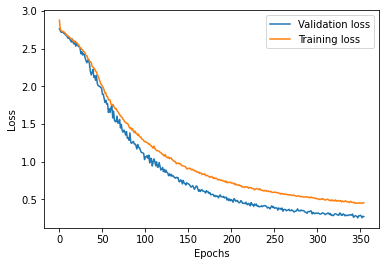

In [0]:
plt.plot(history.epoch ,history.history['val_loss'], label='Validation loss')
plt.plot(history.epoch, history.history['loss'], label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.style.use('default')
plt.legend()
plt.show()

전체적으로 느리지만 Loss의 발전이 보였음.
Early stopping patient 및 minimum loss에 조금더 관용을 주었을 경우 조금더 오버피팅 되어 원본 데이터를 더 잘 복원하지만, context를 덜 고려하게 되어 AMP activation 측면에서는 손해를 보아 현재의 hyperparameter를 선택


### b) Generate text using RNN model

In [0]:
def generate_text_RNN(model, start_string, temperature, length):
  # 평가 단계 (학습된 모델을 사용하여 텍스트 생성)

  # 시작 문자열을 숫자로 변환(벡터화)
  try:
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)
  except:
    print("protein이 아닌 문자열이 포함되었습니다.")
    return 0

  # 결과를 저장할 빈 문자열
  text_generated = []

  # 의외의 효과를 만드는 온도 상수 추가
  temperature = temperature

  model.reset_states()
  num = 0
  while num < length:
      predictions = model(input_eval)
      # 배치 차원 제거
      predictions = tf.squeeze(predictions, 0)

      # 범주형 분포를 사용하여 모델에서 리턴한 단어 예측
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()


      # 예측된 단어를 다음 입력으로 모델에 전달
      input_eval = tf.expand_dims([predicted_id], 0)
      text_generated.append(idx2char[predicted_id])
      
      # \n 은 sequecne의 끝을 의미하므로
      # 이를 만날때 마다, peptide sequence 하나가 만들어졌다고 인식
      if predicted_id == 0:
        num = num + 1
      printProgress(num,length, 'Progress=', 'Completed', 1, 50)
  result = []
  temp = []

  # 만들어진 peptide text sequence를 재가공하여 return
  for item in text_generated:
    temp.append(item)
    if item == '\n':
      result.append(''.join(temp))
      temp = []
  return result

In [0]:
# 만들어진 Peptide sequence를 pasta 형태로 저장하는 function
# CAMP3 의 AMP activation test의 input 형태에 맞추기 위한 과정
def result_csv_generator_RNN(model, seed, temperature, file_name, length):
  result = []
  temp = generate_text_RNN(model, seed, temperature, length)
  csv = open('result_{}.csv'.format(file_name), 'w')
  i = 0
  for item in temp:
    csv.write('>{}\n'.format(i))
    i = i + 1
    csv.write('{}'.format(item))

  csv.close()

In [0]:
# 학습된 모델의 최적 weight, input batch = 1인 model을 재구성
model = build_model(vocab_size, embedding_dim, rnn_units, 1, file_name)
model.load_weights('/content/bestmodel/Model_{}'.format(file_name))
model.build(tf.TensorShape([1, None]))

In [0]:
# Model을 기반으로 peptide를 만들고, 이를 fasta 형태의 csv file로 저장
result_csv_generator_RNN(model, "FAL", 0.1, file_name, 1000)

Progress= |##################################################| 100.0% Completed


## 2) CNN model

### a) Build and train CNN model

In [0]:
# 단일 층의 causal padding으로 구성된 simple CNN
# CNN은 input을 받아 이전보다 한 칸 진행된 sequence를 예측하게된다.
def build_model(seq_length, vocab):
  model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(20, 100, padding='causal', kernel_initializer='glorot_normal', activation='relu'),
  ])
  return model

# Conv1D를 위한 Categorical crossentropy 선언
def adjust_categorical_crossentropy(y_true, y_pred):
    __EPS = 1e-5
    y_pred = K.clip(y_pred, __EPS, 1 - __EPS)
    return -K.mean(y_true * K.log(y_pred) + (1 - y_true) * K.log(1 - y_pred))

In [0]:
model = build_model(seq_length, vocab)

model.compile(optimizer='adam', loss=adjust_categorical_crossentropy)

es = tf.keras.callbacks.EarlyStopping(patience=5, min_delta=0.01)
history = model.fit(x=X_train, y=y_train, batch_size=128, epochs=500, callbacks=[es], validation_data=(X_val, y_val))

Epoch 1/500
211/211 [==============================] - 1s 6ms/step - loss: 0.2398 - val_loss: 0.1917
Epoch 2/500
211/211 [==============================] - 1s 5ms/step - loss: 0.1782 - val_loss: 0.1687
Epoch 3/500
211/211 [==============================] - 1s 5ms/step - loss: 0.1636 - val_loss: 0.1598
Epoch 4/500
211/211 [==============================] - 1s 6ms/step - loss: 0.1567 - val_loss: 0.1542
Epoch 5/500
211/211 [==============================] - 1s 5ms/step - loss: 0.1537 - val_loss: 0.1526
Epoch 6/500
211/211 [==============================] - 1s 5ms/step - loss: 0.1522 - val_loss: 0.1536
Epoch 7/500
211/211 [==============================] - 1s 5ms/step - loss: 0.1539 - val_loss: 0.1537
Epoch 8/500
211/211 [==============================] - 1s 6ms/step - loss: 0.1532 - val_loss: 0.1537
Epoch 9/500
211/211 [==============================] - 1s 6ms/step - loss: 0.1509 - val_loss: 0.1513


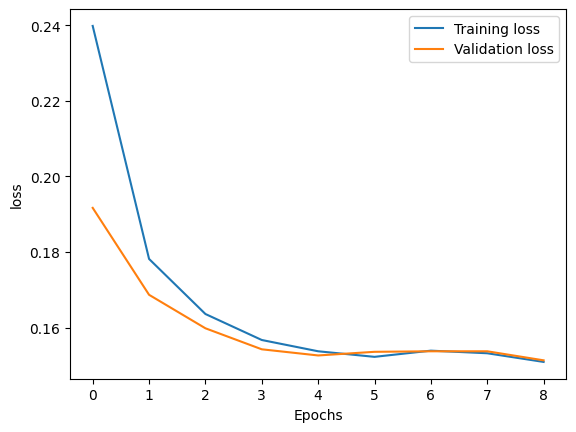

In [0]:
plt.plot(history.epoch, history.history['loss'], label = 'Training loss')
plt.plot(history.epoch, history.history['val_loss'], label = 'Validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

### b) Generate text using CNN model

In [0]:
# 학습된 CNN 모델을 기반으로 Peptide를 생성하는 model

def generate_text_CNN(model, seed, length):
  model = model
  input_seq = seed
  result = ""
  num = 0
  while num < length:
    # input sequence와 model을 기반으로 한 칸 뒤의 sequence를 예측
    input_seq_np = np.array([[char2idx[c] for c in input_seq]])
    input_seq_onehot = tf.keras.utils.to_categorical(input_seq_np, 20)
    prediction = model(input_seq_onehot)[0][-1].numpy().tolist()
    
    # 예측 확률을 기반으로 마지막 sequence를 예측
    predicted_id = random.choices(range(20), weights=prediction, k=1)
    added_id = idx2char[predicted_id][0]
    
    # Input sequence의 가장 첫 서열을 잘라내고,
    # 예측된 sequence를 붙여 다시 input을 형성
    input_seq = input_seq[1:] + added_id
    result = result + added_id
    
    # \n 은 sequecne의 끝을 의미하므로
    # 이를 만날때 마다, peptide sequence 하나가 만들어졌다고 인식
    if added_id == '\n' and result[-2] != '\n':
      num = num + 1
    
    # 함수의 내부 진행사항을 표시하는 함수
    printProgress(num,length, 'Progress=', num, 1, 50)

  return result

In [0]:
# generate_text_CNN을 이용해 만든 peptide sequence를
# CAMP3를 위한 fasta format으로 변형 저장하는 function
def result_csv_generator_CNN(model, seed, file_name, length):
  temp = generate_text_CNN(model, seed, length)
  csv = open('result_{}.csv'.format(file_name), 'w')
  
  i = 0
  pre_item = 'A'
  csv.write('>{}\n'.format(i))
  for item in temp:
    if pre_item != '\n':
      csv.write(item)
      if item == '\n':
        i = i + 1
        csv.write('>{}\n'.format(i))
    
    pre_item = item

  return temp

In [0]:
file_name = 'CNN'

# training sample의 100번까지를 text generation을 위한
# Seed로 제공하여 새로운 peptide seuqence를 생성
seed = text[:100]
result = result_csv_generator_CNN(model, seed, file_name, 1000)

Progress= |##################################################| 100.0% 1000


# 3. Validate AMP activity

In [0]:
# Training set의 AMP activity를 확인하기 위해
# Training set을 fasta format으로 변형하는 과정
df = pd.read_csv('/content/LSTM_peptides/training_sequences_noC.csv', header=None)
training_prop = open('training_prop.csv', 'w')

i = 0
for item in df[0]:
  training_prop.write('>{}\n'.format(i))
  training_prop.write(item)
  training_prop.write('\n')
  i = i + 1

In [0]:
# Random sequence generation
# Training set의 amino acid 비율에 따라 Random sequence를 형성
# Training 및 generated sequence와 비교하기 위해 사용

# Training set (text) 내의 모든 amino acid의 갯수를 합산
ratio = [i*0 for i in range(20)]
for item in text:
  ratio[char2idx[item]] = ratio[char2idx[item]] + 1

# amino acid의 비율 계산
total_length = sum([i for i in ratio])
ratio = [i/total_length for i in ratio]
prob = [sum(ratio[:i+1]) for i in range(20)]
idx2char_list = idx2char.tolist()

# Random sequence에 포함될 peptide의 갯수를 선언
random_num = 1000

# Random seuqence 생성
random_seq = []
latter = 'A'
while len(random_seq) < random_num:
  temp = ''
  latter = 'A'
  while latter != '\n':
    latter = idx2char_list[np.random.choice(20, 1, p=ratio).tolist()[0]][0]
    temp = temp + latter
  
  if temp != '\n':
    random_seq.append(temp)
  printProgress(len(random_seq),random_num, 'Progress=', 'Completed', 1, 50)

# Fasta format의 csv file로 저장, CAMP3 AMP activity 분석을 진행
f = open('random.csv', 'w')
i = 0
for item in random_seq:
  f.write('>{}\n'.format(i))
  f.write(item)
  i = i + 1
f.close()

Progress= |##################################################| 100.0% Completed


In [0]:
upload = files.upload()

In [0]:
From_GoogleDrive = True #@param {type:"boolean"}

if From_GoogleDrive == False:
  trainingset_prop = pd.read_csv('/content/training.csv')
  result_prop_RNN = pd.read_csv('/content/RNN_result.csv')
  result_prop_CNN = pd.read_csv('/content/CNN_result.csv')
  random_prop = pd.read_csv('/content/random.csv')

else:
  trainingset_prop = pd.read_csv('/content/drive/My Drive/training.csv')
  result_prop_RNN = pd.read_csv('/content/drive/My Drive/RNN_result.csv')
  result_prop_CNN = pd.read_csv('/content/drive/My Drive/CNN_result.csv')
  random_prop = pd.read_csv('/content/drive/My Drive/random.csv')

In [0]:
# scipy의 ttest module을 활용 결과의 CAMP3 AMP activity가
# 유의미하게 차이 있는지 p value 계산
p_train2result_RNN = scipy.stats.ttest_ind(trainingset_prop['prob'], result_prop_RNN['prob'], equal_var=False).pvalue
p_result2random_RNN = scipy.stats.ttest_ind(result_prop_RNN['prob'], random_prop['prob'], equal_var=False).pvalue

p_train2result_CNN = scipy.stats.ttest_ind(trainingset_prop['prob'], result_prop_CNN['prob'], equal_var=False).pvalue
p_result2random_CNN = scipy.stats.ttest_ind(result_prop_CNN['prob'], random_prop['prob'], equal_var=False).pvalue

In [0]:
print("================ P value for RNN T-test ================\n")
print("between training set and result = ", p_train2result_RNN)
print("between random set and result = ", p_result2random_RNN)

================ P value for RNN T-test ================

between training set and result =  0.0002281317243468403
between random set and result =  1.3534828801544558e-143


In [0]:
print("================ P value for CNN T-test ================\n")
print("between training set and result = ", p_train2result_CNN)
print("between random set and result = ", p_result2random_CNN)

================ P value for CNN T-test ================

between training set and result =  0.015381054633881175
between random set and result =  2.0254695338763288e-110


In [0]:
# Visualization module
def Violin_plot(ax1, trainingset_prop, result_prop, random_prop, numstar1, numstar2):
  plt.sca(ax1)
  ax1.set_ylim((-0.025,1.1))
  plt.xticks([1,2,3],['Training set','Generated peptide', 'Random'])
  ax1.set_ylabel("probability")
  ax1.set_xlabel("Dataset")
  training = trainingset_prop['prob']
  result = result_prop['prob']
  random = random_prop['prob']
  bp1 = ax1.violinplot(training, [1], widths=0.7, showmedians=True)
  bp2 = ax1.violinplot(result, [2], widths=0.7, showmedians=True)
  bp3 = ax1.violinplot(random, [3], widths=0.7, showmedians=True)


  ax1.plot([1.05, 1.05, 1.95, 1.95], [1.02, 1.05, 1.05, 1.02], lw=1.4, c='k')
  ax1.text(1.5, 1.06, "*"* numstar1,
        horizontalalignment='center',
        verticalalignment='center')

  ax1.plot([2.05, 2.05, 2.95, 2.95], [1.02, 1.05, 1.05, 1.02], lw=1.4, c='k')
  ax1.text(2.5, 1.06, "*"* numstar2,
        horizontalalignment='center',
        verticalalignment='center')

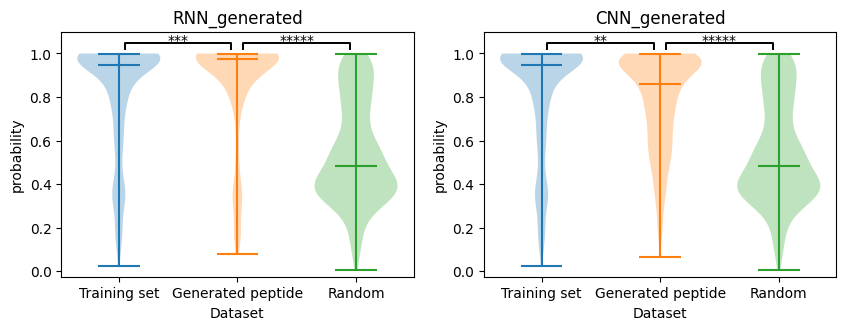

In [0]:
fig_Generation = plt.figure(figsize=(10,7))
ax1 = fig_Generation.add_subplot(221)
ax1.set_title("RNN_generated")
ax2 = fig_Generation.add_subplot(222)
ax2.set_title('CNN_generated')


Violin_plot(ax1, trainingset_prop, result_prop_RNN, random_prop, 3, 5)
Violin_plot(ax2, trainingset_prop, result_prop_CNN, random_prop, 2, 5)

# 4. Regressive model using causal 1D Convolutional layers

In [0]:
# fasta file을 열어 list형태로 전환하는 모듈
def fasta_to_list(fasta_dir):
  f = open(fasta_dir, 'r')
  read = f.readlines()
  result = []
  for item in read:
    if item[0] != '>':
      item.rstrip('\n')
      result.append(item)
  return result

In [0]:
reg_pd = pd.read_csv('/content/LSTM_peptides/training_sequences_noC.csv', header=None)[0]
reg_label = pd.read_csv('/content/drive/My Drive/training.csv')['prob']

In [0]:
temp1 = []
temp2 = []
for item in input_pd:
  for token in item:
    temp1.append(char2idx[token])
  while len(temp1) < 50:
    temp1.append(0)
  temp2.append(temp1)
  temp1 = []

reg_input = np.array(temp2)
reg_input = tf.keras.utils.to_categorical(reg_input, num_classes=20)

In [232]:
reg_input.shape

(1554, 50, 20)

In [0]:
def regression_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(50,20)),
    tf.keras.layers.Conv1D(64, 4, padding='causal', kernel_initializer='glorot_normal', activation='relu'),
    tf.keras.layers.Conv1D(32, 4, dilation_rate=1 ,padding='causal', kernel_initializer='glorot_normal', activation='relu'),
    tf.keras.layers.Conv1D(32, 4, dilation_rate=2 ,padding='causal', kernel_initializer='glorot_normal', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, kernel_initializer='glorot_normal', activation='sigmoid')
  ])
  return model

In [262]:
model = regression_model()
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_46 (Conv1D)           (None, 50, 64)            5184      
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 50, 32)            8224      
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 50, 32)            4128      
_________________________________________________________________
flatten_11 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1600)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 1601      
Total params: 19,137
Trainable params: 19,137
Non-trainable params: 0
_________________________________________________

In [263]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.MSE)
es_reg = tf.keras.callbacks.EarlyStopping(patience=10, min_delta=0.0001)
history = model.fit(x=reg_input, y=reg_label, epochs = 200, callbacks=[es_reg], batch_size=32, validation_split=0.2)

Epoch 1/200
39/39 [==============================] - 0s 6ms/step - loss: 0.0823 - val_loss: 0.0419
Epoch 2/200
39/39 [==============================] - 0s 4ms/step - loss: 0.0357 - val_loss: 0.0207
Epoch 3/200
39/39 [==============================] - 0s 4ms/step - loss: 0.0200 - val_loss: 0.0116
Epoch 4/200
39/39 [==============================] - 0s 4ms/step - loss: 0.0140 - val_loss: 0.0098
Epoch 5/200
39/39 [==============================] - 0s 4ms/step - loss: 0.0112 - val_loss: 0.0081
Epoch 6/200
39/39 [==============================] - 0s 4ms/step - loss: 0.0088 - val_loss: 0.0084
Epoch 7/200
39/39 [==============================] - 0s 4ms/step - loss: 0.0075 - val_loss: 0.0080
Epoch 8/200
39/39 [==============================] - 0s 4ms/step - loss: 0.0060 - val_loss: 0.0071
Epoch 9/200
39/39 [==============================] - 0s 4ms/step - loss: 0.0055 - val_loss: 0.0069
Epoch 10/200
39/39 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0075
Epoch 11/

In [0]:
pred = model.predict(reg_input)

In [0]:
p_train2result_reg = scipy.stats.ttest_ind(trainingset_prop['prob'], pred)

In [266]:
p_train2result_reg.pvalue

array([0.84903651])

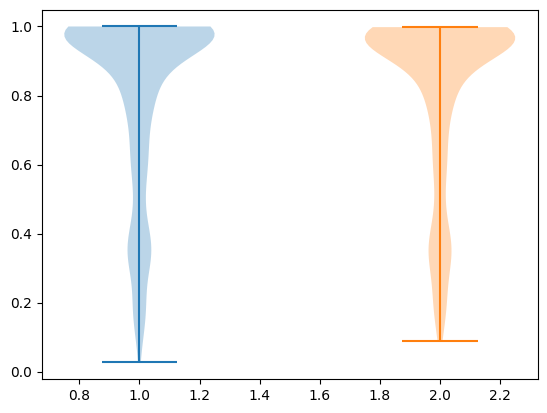

In [267]:
fig_reg = plt.figure()
ax1 = fig_reg.add_subplot(111)
bp1 = ax1.violinplot(reg_label, [1])
bp2 = ax1.violinplot(pred,[2])

# 5. Compare with reference

/usr/local/lib/python3.6/dist-packages/modlamp/analysis.py:300: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  counts, bins = np.histogram(c, range=[-5, 20], bins=25, normed=True)


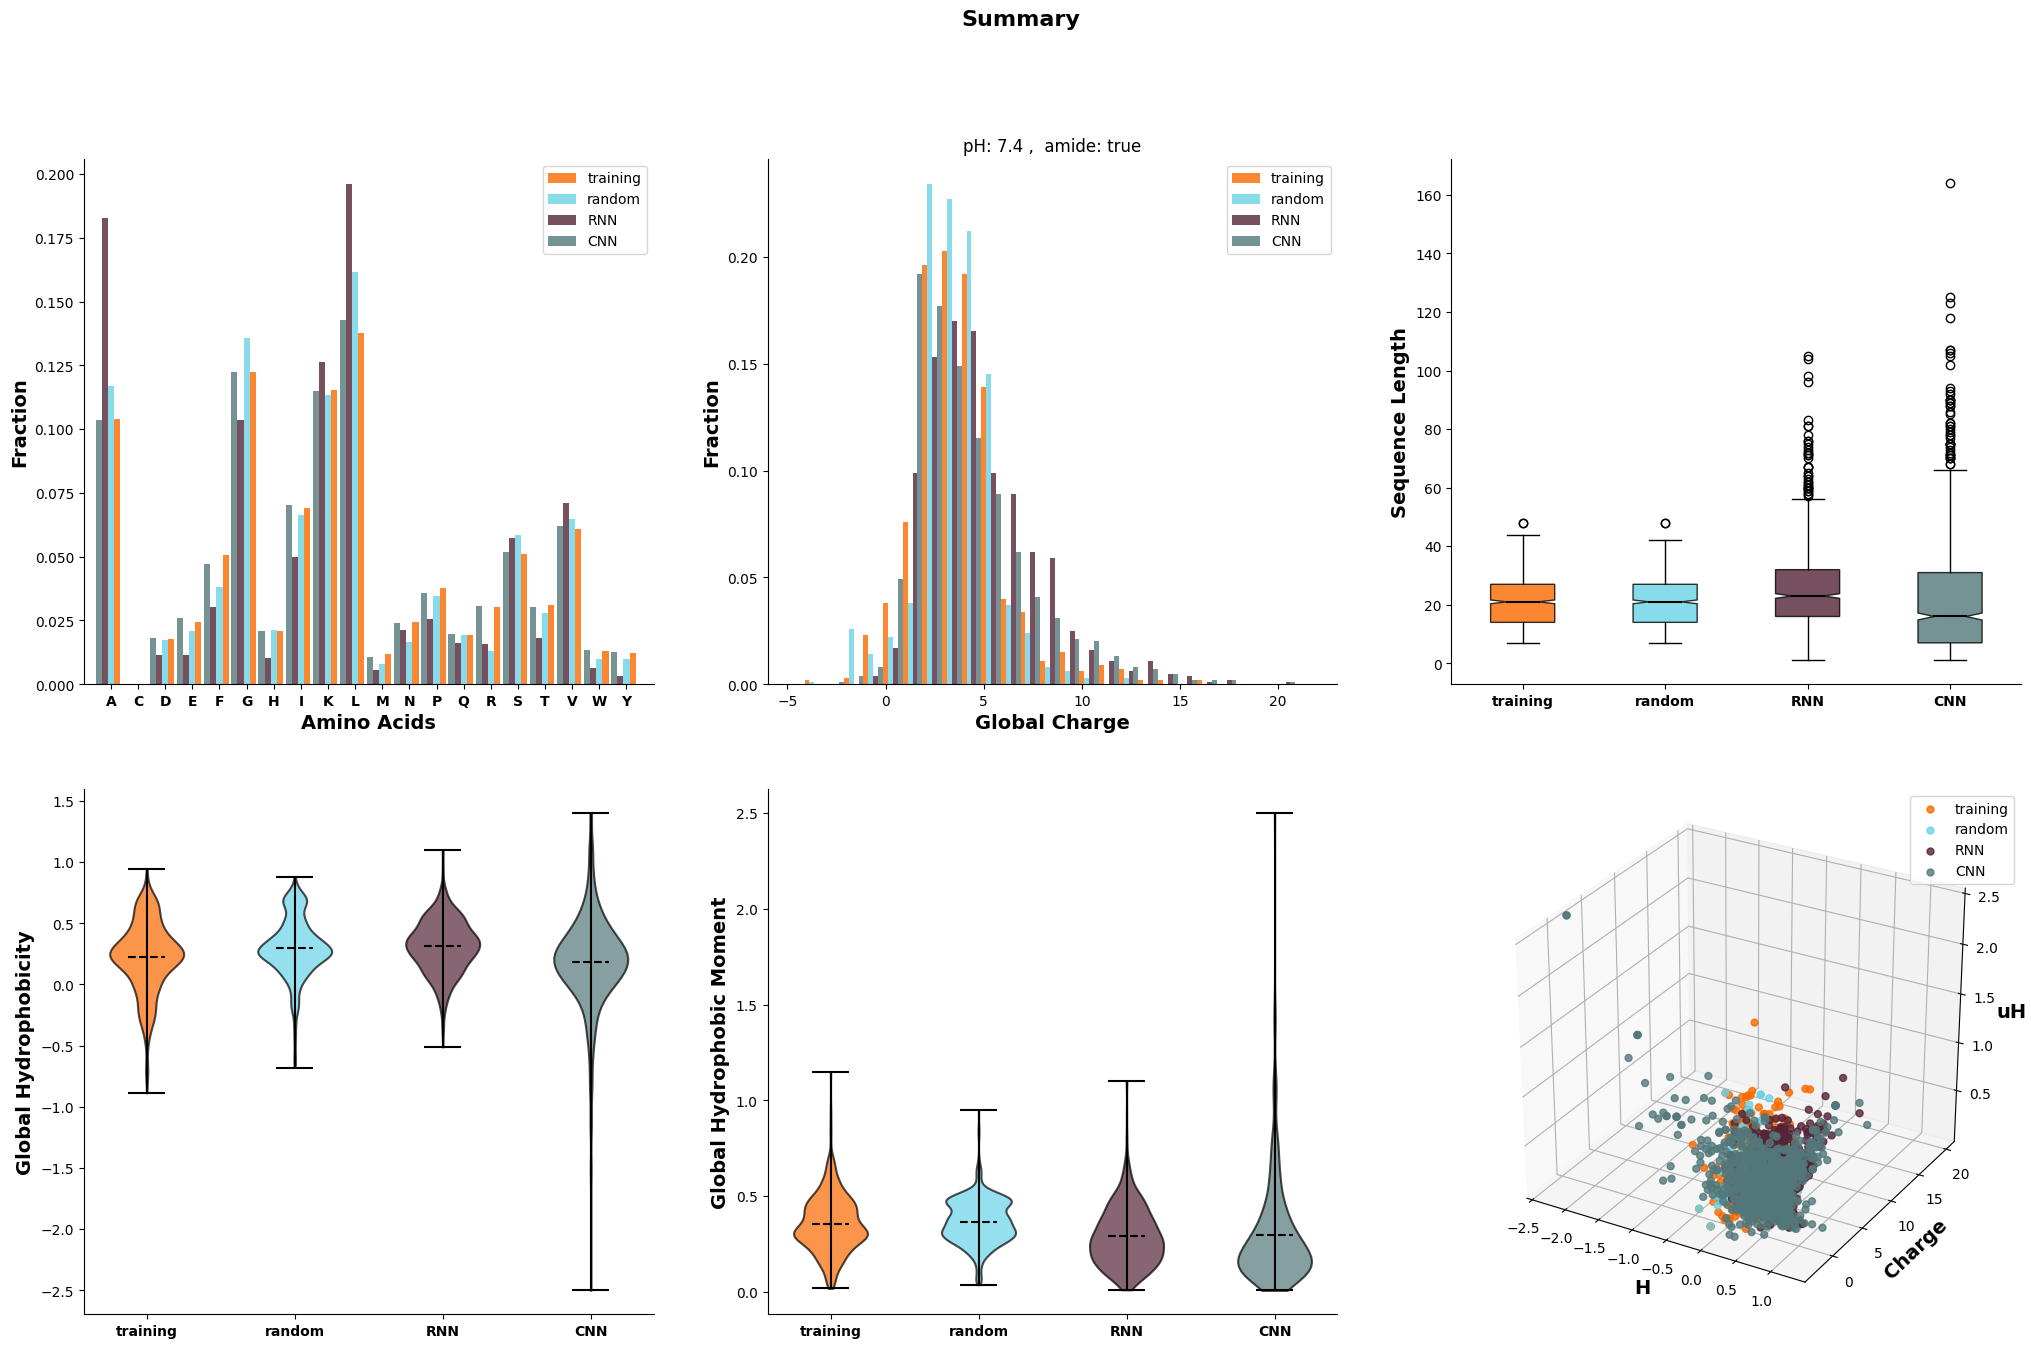

In [0]:
from modlamp.analysis import GlobalAnalysis

seq_random = fasta_to_list('/content/random.csv')
seq_CNN = fasta_to_list('/content/result_CNN.csv')
seq_RNN = fasta_to_list('/content/result_RNN.csv')
seq_training = fasta_to_list('/content/training_prop.csv')[:1000]

analysis_target = [seq_training, seq_RNN, seq_CNN, seq_random]
analysis = GlobalAnalysis(analysis_target, names=['training', 'random' , 'RNN', 'CNN'])
anal_result = analysis.plot_summary(plot=True)


<img src="https://pubs.acs.org/na101/home/literatum/publisher/achs/journals/content/jcisd8/2018/jcisd8.2018.58.issue-2/acs.jcim.7b00414/20180220/images/large/ci-2017-00414w_0005.jpeg" width='2000'>


In [0]:
!mkdir -p helical

In [0]:
from modlamp.plot import helical_wheel

seq = ['GWGSFFRKIAKIAKKVGSTFLNNIL', 'GIGTKILGGVKTALKGALKELAPTYVN', 'FLPLVGKILSGLI', 'GIGAAILSAGKSALKGLAKGLAEHF']

for item in seq:
  helical_wheel(item, moment=True, colorcoding='charge', filename='/content/helical/{}.png'.format(item))

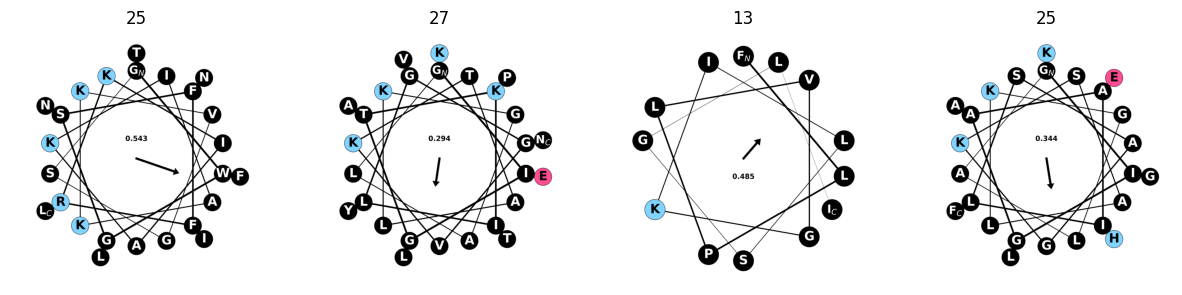

In [302]:
hel_fig = plt.figure(figsize=(15,5))

h1 = hel_fig.add_subplot(141)
h1.axis('off')
h2 = hel_fig.add_subplot(142)
h2.axis('off')
h3 = hel_fig.add_subplot(143)
h3.axis('off')
h4 = hel_fig.add_subplot(144)
h4.axis('off')

h1.imshow(plt.imread("./helical/{}.png".format(seq[0])))
h1.set_title(len(seq[0]))
h2.imshow(plt.imread("./helical/{}.png".format(seq[1])))
h2.set_title(len(seq[1]))
h3.imshow(plt.imread("./helical/{}.png".format(seq[2])))
h3.set_title(len(seq[2]))
h4.imshow(plt.imread("./helical/{}.png".format(seq[3])))
h4.set_title(len(seq[3]))

fig.show()

<img src="https://pubs.acs.org/na101/home/literatum/publisher/achs/journals/content/jcisd8/2018/jcisd8.2018.58.issue-2/acs.jcim.7b00414/20180220/images/large/ci-2017-00414w_0007.jpeg" width='3000'>



<img src="https://pubs.acs.org/na101/home/literatum/publisher/achs/journals/content/jcisd8/2018/jcisd8.2018.58.issue-2/acs.jcim.7b00414/20180220/images/medium/ci-2017-00414w_0006.gif">